In [16]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import mpmath

from ray_delay.device_simulator.noise_model_patch import NoiseModelPatch
from stim_surface_code.memory import MemoryPatch
from stim_surface_code.patch import Qubit, DataQubit, MeasureQubit

from mpl_toolkits.axes_grid1 import make_axes_locatable

import qc_utils.plot as plot_utils

In [2]:
dx = 7
dz = 15
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
center_qubit = patch.patch.device[dx][dz].idx

<Axes: >

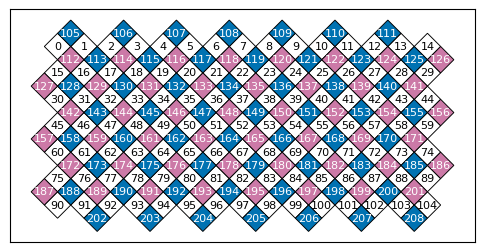

In [3]:
patch.patch.plot_qubit_vals(font_size=8)

In [4]:
ray_radius = 6
ray_qubit = 55
spectator_patch_data_qubits = []
ray_patch_data_qubits = []
for row in range(7):
    for col in range(15):
        idx = row*15 + col
        if col < 7:
            spectator_patch_data_qubits.append(idx)
        elif col > 7:
            ray_patch_data_qubits.append(idx)

# Getting baseline and cosmic-ray-induced detector fractions

In [5]:
syndrome_qubits = patch.patch.get_syndrome_qubits()

In [6]:
patch.reset()
baseline_fractions = np.mean(patch.patch.count_detection_events(1e6, return_full_data=True)[0], axis=0)

patch.force_cosmic_ray(ray_qubit, ray_radius)
ray_fractions = np.mean(patch.patch.count_detection_events(1e6, return_full_data=True)[0], axis=0)

In [7]:
baseline_fractions_labeled = {q.idx: baseline_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}
ray_fractions_labeled = {q.idx: ray_fractions[i] for i,q in enumerate(patch.patch.get_syndrome_qubits())}

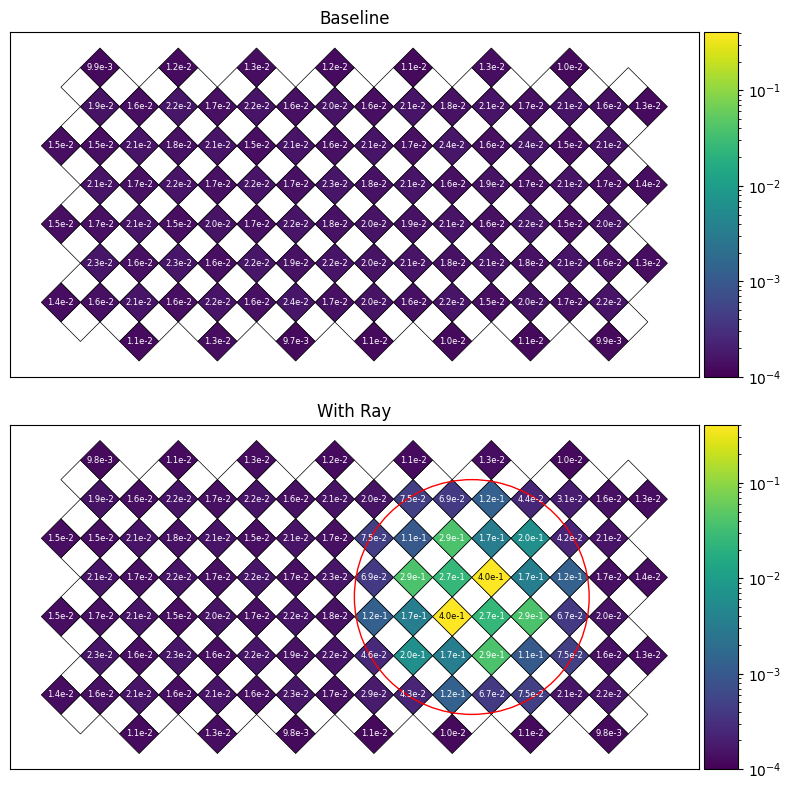

In [8]:
# todo: make function in patch that draws the patch with arbitrary values
# plotted at each qubit / connection (then we can plot the fractions by
# specifying values for only the ancilla qubits)

vmin = 1e-4
vmax = np.max(ray_fractions)
norm = mpl.colors.LogNorm
cmap = 'viridis'
fig,ax = plt.subplots(2,1, figsize=(8,8))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = baseline_fractions[i]
patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[0], font_size=6, vmin=vmin, vmax=vmax, norm=norm, plot_text='val', cmap_name=cmap)
ax[0].set_title('Baseline')

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = ray_fractions[i]
patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[1], font_size=6, vmin=vmin, vmax=vmax, norm=norm, plot_text='val', cmap_name=cmap)
ax[1].add_patch(plt.Circle((patch.patch.qubit_name_dict[ray_qubit].coords[1], patch.patch.qubit_name_dict[ray_qubit].coords[0]), ray_radius, color='r', fill=False))
ax[1].set_title('With Ray')

plt.tight_layout()
plt.savefig('longpatch_ray.png', dpi=300)

# Sweeping over window sizes

In [9]:
def _initialize_windows(
        device: list[list[Qubit | None]],
        spatial_window_size: int,
    ) -> list[list[int]]:
    """Initialize spatial windows that we will use to detect cosmic rays.
    
    Args:
        device: The layout of the device, in the form of a 2D list of Qubit
            objects.
    """
    assert spatial_window_size < len(device) and spatial_window_size < len(device[0])
    window_rows = len(device) - spatial_window_size
    window_cols = len(device[0]) - spatial_window_size

    all_windows = []
    for wr in range(window_rows):
        for wc in range(window_cols):
            window_qubits = []
            for r in range(wr, wr + spatial_window_size + 1):
                for c in range(wc, wc + spatial_window_size + 1):
                    qb = device[r][c]
                    if isinstance(qb, Qubit):
                        window_qubits.append(qb.idx)
            if len(window_qubits) > 0:
                all_windows.append(window_qubits)
    return all_windows

In [10]:
mpmath.mp.dps = 50

cycles_per_distillation = 6*dm
max_latency = cycles_per_distillation

fpr = mpmath.mpf(1e-13)
temporal_window_size = 6*dm
spatial_sizes = range(1, 2*dx+1)

ray_true_positive_rates = np.zeros((len(spatial_sizes), max_latency), dtype=mpmath.mpf)
ray_false_positive_rates = np.zeros((len(spatial_sizes), max_latency), dtype=mpmath.mpf)
spectator_true_positive_rates = np.zeros((len(spatial_sizes), max_latency), dtype=mpmath.mpf)
spectator_false_positive_rates = np.zeros((len(spatial_sizes), max_latency), dtype=mpmath.mpf)
for i,spatial_size in enumerate(spatial_sizes):
    # just using RayDetector to get the spatial windowing
    detector_windows = _initialize_windows(patch.patch.device, spatial_size)

    # false positive rate per window to give total false positive rate
    window_fpr = 1 - (1-fpr)**(1/len(detector_windows))
    for latency in range(1, max_latency+1):
        j = latency - 1
        ray_window_tprs = np.zeros(len(detector_windows), dtype=mpmath.mpf)
        ray_window_fprs = np.zeros(len(detector_windows), dtype=mpmath.mpf)
        spectator_window_tprs = np.zeros(len(detector_windows), dtype=mpmath.mpf)
        spectator_window_fprs = np.zeros(len(detector_windows), dtype=mpmath.mpf)
        for k,window in enumerate(detector_windows):
            stabilizer_window = [q for q in window if isinstance(patch.patch.qubit_name_dict[q], MeasureQubit)]
            if len(stabilizer_window) == 0:
                continue
            baseline_mean = np.mean([baseline_fractions_labeled[q] for q in stabilizer_window]) # mean per qubit per round
            ray_mean = np.mean([ray_fractions_labeled[q] for q in stabilizer_window])

            # threshold of detections where we say it is outside of the baseline regime
            detection_threshold = scipy.stats.binom.ppf(float(1-window_fpr), len(stabilizer_window)*temporal_window_size, baseline_mean)

            # chance that baseline generates more than threshold detections
            false_positive = 1-scipy.stats.binom.cdf(detection_threshold, len(stabilizer_window)*temporal_window_size, baseline_mean)
            
        
            if latency <= temporal_window_size:
                # some part of window is at baseline rate (before ray has hit)
                windowed_syndrome_rate = baseline_mean*(1-latency/temporal_window_size) + ray_mean*(latency/temporal_window_size)
            else:
                windowed_syndrome_rate = ray_mean
            true_positive = 1-scipy.stats.binom.cdf(detection_threshold, len(stabilizer_window)*temporal_window_size, windowed_syndrome_rate)

            if len(set(window).intersection(set(ray_patch_data_qubits))) > 0:
                ray_window_fprs[k] = mpmath.mpf(false_positive)
                ray_window_tprs[k] = mpmath.mpf(true_positive)
            elif len(set(window).intersection(set(spectator_patch_data_qubits))) > 0:
                spectator_window_fprs[k] = mpmath.mpf(false_positive)
                spectator_window_tprs[k] = mpmath.mpf(true_positive)
        ray_false_positive_rates[i,j] = 1 - np.prod(1 - ray_window_fprs)
        ray_true_positive_rates[i,j] = 1 - np.prod(1 - ray_window_tprs)
        spectator_false_positive_rates[i,j] = 1 - np.prod(1 - spectator_window_fprs)
        spectator_true_positive_rates[i,j] = 1 - np.prod(1 - spectator_window_tprs)

cumulative_ray_no_signal_rates = np.cumprod(1-ray_true_positive_rates, axis=1)
cumulative_ray_true_positive_rates = 1 - cumulative_ray_no_signal_rates
cumulative_ray_no_signal_rates_baseline = np.cumprod(1-ray_false_positive_rates, axis=1)
cumulative_ray_false_positive_rates = 1 - cumulative_ray_no_signal_rates_baseline

cumulative_spectator_no_signal_rates = np.cumprod(1-spectator_true_positive_rates, axis=1)
cumulative_spectator_true_positive_rates = 1 - cumulative_spectator_no_signal_rates
cumulative_spectator_no_signal_rates_baseline = np.cumprod(1-spectator_false_positive_rates, axis=1)
cumulative_spectator_false_positive_rates = 1 - cumulative_spectator_no_signal_rates_baseline

/Users/jchad/Library/Caches/pypoetry/virtualenvs/ray-delay-mG6OZh6y-py3.11/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:90: RuntimeWarning: overflow encountered in _binom_ppf
  return _boost._binom_ppf(q, n, p)


In [11]:
# make sure false positive rate is below set threshold
assert np.all(spectator_false_positive_rates.astype(float) < fpr)

In [12]:
threshold = 1-1e-5
ray_detection_latencies = np.argmax(cumulative_ray_true_positive_rates > threshold, axis=1)
ray_detection_latencies[ray_detection_latencies == 0] = max_latency+1

In [14]:
norm(1e-2)

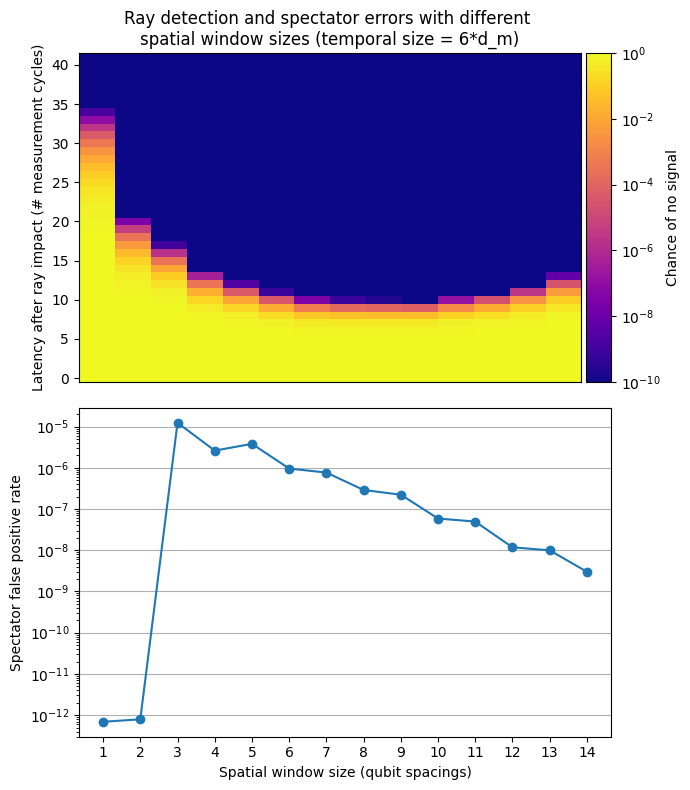

In [55]:
fig,ax = plt.subplots(2,1, figsize=(7,8))
min_err = 1e-10
max_err = 1.0-1e-10
num_lines = 100
norm = mpl.colors.LogNorm(vmin=min_err, vmax=max_err)
cmap = mpl.colormaps['plasma']

plot_vals = cumulative_ray_no_signal_rates.T.astype(float)
plot_vals[plot_vals == 0] = min_err

ax[1].plot([s-1 for s in spatial_sizes], cumulative_spectator_true_positive_rates[:,-1], 'o-', label='Spectator false positive rate')
ax[1].grid(axis='y')
ax[1].set_yscale('log')
ax[1].set_ylabel('Spectator false positive rate')

ax[0].imshow(plot_vals, norm=norm, cmap=cmap, origin='lower', aspect='auto', interpolation='none')
ax[1].set(xticks=range(0, spatial_sizes[-1], 1), xticklabels=range(1, spatial_sizes[-1]+1, 1))
ax[0].set_xticks([], [])
cbar = plot_utils.add_cbar(ax[0], norm, cmap)
cbar.set_label('Chance of no signal')
ax[1].set_xlabel('Spatial window size (qubit spacings)')
ax[0].set_ylabel('Latency after ray impact (# measurement cycles)')

ax[0].set_title('Ray detection and spectator errors with different \nspatial window sizes (temporal size = 6*d_m)')

# plt.legend()
plt.tight_layout()
plt.savefig('window_sizes.png', dpi=300)